## Read SCR and extract latent learning rate

In [1]:
%config Completer.use_jedi = False

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import theano
import theano.tensor as tt
import scipy

import pymc3 as pm
import arviz as az
# import learning package
#import DMpy

In [2]:
scr = pd.read_csv('Behavioral/SCR3.csv')
scr.head()

,Event.Nr,CDA.nSCR,CDA.Latency,CDA.AmpSum,CDA.SCR,CDA.ISCR,CDA.PhasicMax,CDA.Tonic,TTP.nSCR,TTP.Latency,TTP.AmpSum,Global.Mean,Global.MaxDeflection,Event.NID,Event.Name,Condition,group,sub
0,1,5,0.8435,0.2852,0.0003,0.1339,8.1296,2.3324,1,3.9335,0.5884,2.4822,0.5884,5,5,CSplusUS1,HC,189
1,2,4,0.7335,0.1033,0.0012,0.4737,0.3046,4.0029,0,NaN,0.0000,4.3933,0.0000,5,5,CSminus1,HC,189
2,3,3,2.9835,0.0783,0.0008,0.3237,0.1352,3.9579,1,2.8335,0.0260,3.9900,0.0154,5,5,CSplus1,HC,189
3,4,1,3.4935,0.1772,0.0002,0.0993,7.0748,3.8756,1,3.5335,0.5186,3.9212,0.5186,5,5,CSplusUS1,HC,189
4,5,0,NaN,0.0000,0.0004,0.1532,0.1604,4.2513,0,NaN,0.0000,4.3461,0.0000,5,5,CSminus1,HC,189


<AxesSubplot:xlabel='Event.Nr', ylabel='CDA.PhasicMax'>

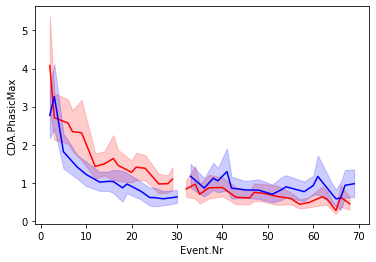

In [3]:
sns.lineplot(x='Event.Nr',y='CDA.PhasicMax', data=scr[(scr.Condition=='CSplus1')], color = 'red')
sns.lineplot(x='Event.Nr',y='CDA.PhasicMax', data=scr[(scr.Condition=='CSminus1')], color='blue')
sns.lineplot(x='Event.Nr',y='CDA.PhasicMax', data=scr[(scr.Condition=='CSplus2')], color='red')
sns.lineplot(x='Event.Nr',y='CDA.PhasicMax', data=scr[(scr.Condition=='CSminus2')], color='blue')

In [37]:
scr['Event.Nr'].values[31:]

array([32, 33, 34, ..., 67, 68, 69])

## Grab the first part of experiment
- i.e. event number <= 30

In [4]:
scr_first = scr[scr['Event.Nr']<=30]
scr_second = scr[scr['Event.Nr']>30]
scr_first.head()

,Event.Nr,CDA.nSCR,CDA.Latency,CDA.AmpSum,CDA.SCR,CDA.ISCR,CDA.PhasicMax,CDA.Tonic,TTP.nSCR,TTP.Latency,TTP.AmpSum,Global.Mean,Global.MaxDeflection,Event.NID,Event.Name,Condition,group,sub
0,1,5,0.8435,0.2852,0.0003,0.1339,8.1296,2.3324,1,3.9335,0.5884,2.4822,0.5884,5,5,CSplusUS1,HC,189
1,2,4,0.7335,0.1033,0.0012,0.4737,0.3046,4.0029,0,NaN,0.0000,4.3933,0.0000,5,5,CSminus1,HC,189
2,3,3,2.9835,0.0783,0.0008,0.3237,0.1352,3.9579,1,2.8335,0.0260,3.9900,0.0154,5,5,CSplus1,HC,189
3,4,1,3.4935,0.1772,0.0002,0.0993,7.0748,3.8756,1,3.5335,0.5186,3.9212,0.5186,5,5,CSplusUS1,HC,189
4,5,0,NaN,0.0000,0.0004,0.1532,0.1604,4.2513,0,NaN,0.0000,4.3461,0.0000,5,5,CSminus1,HC,189


<AxesSubplot:xlabel='Event.Nr', ylabel='CDA.PhasicMax'>

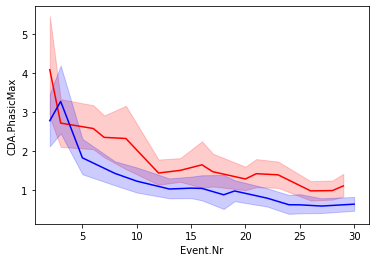

In [39]:
sns.lineplot(x='Event.Nr',y='CDA.PhasicMax', data=scr_first[(scr_first.Condition=='CSplus1')], color = 'red')
sns.lineplot(x='Event.Nr',y='CDA.PhasicMax', data=scr_first[(scr_first.Condition=='CSminus1')], color='blue')

<AxesSubplot:xlabel='Event.Nr', ylabel='CDA.PhasicMax'>

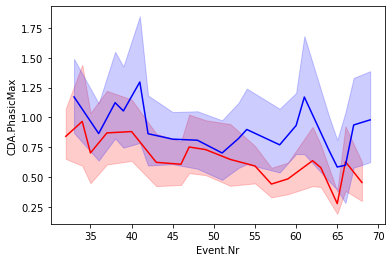

In [40]:
sns.lineplot(x='Event.Nr',y='CDA.PhasicMax', data=scr_second[(scr_second.Condition=='CSplus2')], color = 'red')
sns.lineplot(x='Event.Nr',y='CDA.PhasicMax', data=scr_second[(scr_second.Condition=='CSminus2')], color='blue')

In [41]:
# save data
scr_first.to_csv('firstSCRpart.csv', index=False)
scr_second.to_csv('secondSCRpart.csv', index=False)

# Build a model

In [42]:
# first create CS+ - CS-
# generate total difference between CS+ and CS- for all subjects
subject_list = scr_first['sub'].unique()
subject_list = subject_list
subDict = {}
for sub in subject_list:
   # print(f'Analyzing subject {sub}')
    scrSub = scr_first[scr_first['sub']==sub]
    plus_minus = scrSub[scrSub.Condition=='CSplus1'].mean()['CDA.AmpSum'] - scrSub[scrSub.Condition=='CSminus1'].mean()['CDA.AmpSum']
    subDict[sub] = plus_minus

/tmp/ipykernel_7170/2597750983.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  plus_minus = scrSub[scrSub.Condition=='CSplus1'].mean()['CDA.AmpSum'] - scrSub[scrSub.Condition=='CSminus1'].mean()['CDA.AmpSum']


In [43]:
subDict.keys()

dict_keys([189, 86, 205, 71, 87, 204, 85, 24, 101, 100, 132, 185, 167, 43, 62, 105, 73, 82, 30, 160, 196, 146, 1223, 106, 8, 94, 112, 169, 1222, 55, 170, 131, 47, 177, 89, 130, 172, 200, 173, 26, 59, 1, 72, 1232, 166, 32, 11, 104, 16, 1205, 186, 56, 53, 150, 65, 154, 193, 165, 4, 103, 95, 168, 20, 102, 75, 48, 27, 5, 136, 182, 202, 114, 121, 81, 203, 108, 80, 122, 66, 38, 184, 171, 183, 13, 22, 179, 592, 153, 144, 178, 63, 124, 21, 19, 10, 158, 83, 113, 107, 126, 152])

In [44]:
df_plusminus = pd.DataFrame({'subject':subDict.keys(), 'plusMinus':subDict.values()})
df_plusminus.head()

,subject,plusMinus
0,189,0.042992
1,86,-0.080975
2,205,0.248292
3,71,-0.055083
4,87,0.512283


In [ ]:
df_plusminus.describe()

In [ ]:
dfGroup = scr[scr['Event.Nr']==1][['sub','group']]

#dfBoth = pd.merge(dfGroup, df_plusminus)
df_plusminus = df_plusminus.merge(dfGroup, left_on='subject', right_on='sub')


In [ ]:
df_plusminus.groupby('group').describe()
#sns.boxplot(df_plusminus, x='group_x', y='plusMinus')

In [ ]:
#plt.boxplot(df_plusminus.group, df_plusminus.plusMinus)
df_plusminus.boxplot('plusMinus','group')

In [ ]:
#df_plusminus = df_plusminus.drop('sub', axis=1)
df_plusminus.to_csv('plus_minus.csv', index=False)

In [ ]:
# take only last 15 trials
scr_2nd = scr[(scr['Event.Nr']<=30) & (scr['Event.Nr']>=15) ]
#.head()
subject_list = scr_2nd['sub'].unique()
subject_list = subject_list
subDict = {}
for sub in subject_list:
   # print(f'Analyzing subject {sub}')
    scrSub = scr_2nd[scr_2nd['sub']==sub]
    plus_minus = scrSub[scrSub.Condition=='CSplus1'].mean()['CDA.AmpSum'] - scrSub[scrSub.Condition=='CSminus1'].mean()['CDA.AmpSum']
    subDict[sub] = plus_minus


In [ ]:
df_plusminus = pd.DataFrame({'subject':subDict.keys(), 'plusMinus':subDict.values()})
dfGroup = scr[scr['Event.Nr']==1][['sub','group']]

#dfBoth = pd.merge(dfGroup, df_plusminus)
df_plusminus = df_plusminus.merge(dfGroup, left_on='subject', right_on='sub')
df_plusminus.describe()

df_plusminus.to_csv('plus_minus_2.csv', index= False)

# Build Simple RW model

In [52]:
v = 0.001 # set low value

# for loop over trials and adjust value
dfSub = scr_first[scr_first['sub']==20]
print(dfSub.columns)
dfSub.head()


Index(['Event.Nr', 'CDA.nSCR', 'CDA.Latency', 'CDA.AmpSum', 'CDA.SCR',
       'CDA.ISCR', 'CDA.PhasicMax', 'CDA.Tonic', 'TTP.nSCR', 'TTP.Latency',
       'TTP.AmpSum', 'Global.Mean', 'Global.MaxDeflection', 'Event.NID',
       'Event.Name', 'Condition', 'group', 'sub'],
      dtype='object')


,Event.Nr,CDA.nSCR,CDA.Latency,CDA.AmpSum,CDA.SCR,CDA.ISCR,CDA.PhasicMax,CDA.Tonic,TTP.nSCR,TTP.Latency,TTP.AmpSum,Global.Mean,Global.MaxDeflection,Event.NID,Event.Name,Condition,group,sub
4251,1,2,2.5555,1.4921,0.0169,6.7519,4.8289,11.3532,2,1.8455,3.8592,11.9648,1.9635,5,5,CSplusUS1,HC,20
4252,2,1,2.1655,0.6221,0.0060,2.4060,3.5987,13.8089,1,1.7755,0.5078,14.5144,0.5078,5,5,CSminus1,HC,20
4253,3,2,0.8555,1.0079,0.0111,4.4300,4.6874,14.1071,2,0.9755,0.9278,14.7803,0.9248,5,5,CSplus1,HC,20
4254,4,2,1.9555,0.4850,0.0044,1.7778,2.4970,14.0052,5,0.8355,0.6376,14.2787,0.5477,5,5,CSplusUS1,HC,20
4255,5,1,4.3755,0.0614,0.0004,0.1733,0.5385,14.0633,5,1.4655,0.1169,14.2161,0.0330,5,5,CSminus1,HC,20


In [53]:
# build vectors of the relevant data
scrVec = dfSub['CDA.AmpSum'].values
print(scrVec.shape)
shockVec = np.zeros(len(scrVec), dtype=np.int32) # vector to capture shock (1=yes, 0=no)
stimVec = np.zeros(len(scrVec), dtype=np.int32) # vector to capture stimulus (1=CS+, 0= CS-)
for i, cond in enumerate(dfSub['Condition'].values):
    #print(i)
    if cond=='CSplusUS1':
        shockVec[i]= 1
        stimVec[i] = 1
    else:
        shockVec[i] = 0
        if cond=='CSminus1':
            stimVec[i] = 0
        else:
            stimVec[i] = 1
print(shockVec.shape)
print(stimVec.shape)
nTrials = len(dfSub['Event.Nr']) # grab number of trials

(30,)
(30,)
(30,)


# MLE estimation

In [14]:
def llik_td(x, *args):
    # Extract the arguments as they are passed by scipy.optimize.minimize
    alpha, beta = x
    actions, rewards = args
# Initialize values
    Q = np.array([.5, .5])
    log_prob_actions = np.zeros(len(actions))

    for t, (a, r) in enumerate(zip(actions,rewards)):
    # Apply the softmax transformation
        Q_ = Q * beta
        log_prob_action = Q_ - scipy.special.logsumexp(Q_)

        # Store the log probability of the observed action
        log_prob_actions[t] = log_prob_action[a]

        # Update the Q values for the next trial
        Q[a] = Q[a] + alpha * (r - Q[a])

# Return the negative log likelihood of all observed actions
    return -np.sum(log_prob_actions[1:])

In [15]:
import scipy
llik_td([0.5, 0.5], *(stimVec, shockVec))

19.7435204991124

In [50]:
def update_Q(action, reward,
             Qs,
             alpha):
    """
    This function updates the Q table according to the RL update rule.
    It will be called by theano.scan to do so recursevely, given the observed data and the alpha parameter
    This could have been replaced be the following lamba expression in the theano.scan fn argument:
        fn=lamba action, reward, Qs, alpha: tt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    """

    Qs = tt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    return Qs

In [18]:
# Transform the variables into appropriate Theano objects
rewards_ = theano.shared(np.asarray(shockVec, dtype='int16'))
actions_ = theano.shared(np.asarray(stimVec, dtype='int16'))

alpha = tt.scalar("alpha")
beta = tt.scalar("beta")

# Initialize the Q table
Qs = 0.5 * tt.ones(2, dtype='float64')

# Compute the Q values for each trial
Qs, _ = theano.scan(
    fn=update_Q,
    sequences=[actions_, rewards_],
    outputs_info=[Qs],
    non_sequences=[alpha])

# Apply the softmax transformation
Qs_ = Qs * beta
log_prob_actions = Qs_ - pm.math.logsumexp(Qs_, axis=1)

# Calculate the negative log likelihod of the observed actions
log_prob_actions = log_prob_actions[tt.arange(actions_.shape[0]-1), actions_[1:]]
neg_log_like = -tt.sum(log_prob_actions)

In [19]:
theano_llik_td = theano.function(inputs=[alpha, beta], outputs=neg_log_like)
result = theano_llik_td(0.5, 0.5)
float(result)

19.743520499112407

# PyMC model

In [49]:
def theano_llik_td(alpha, beta, actions, rewards):
    rewards = theano.shared(np.asarray(rewards, dtype='int16'))
    actions = theano.shared(np.asarray(actions, dtype='int16'))

    # Compute the Qs values
    Qs = 0.5 * tt.ones((2), dtype='float64')
    Qs, updates = theano.scan(
        fn=update_Q,
        sequences=[actions, rewards],
        outputs_info=[Qs],
        non_sequences=[alpha])

    # Apply the sotfmax transformation
    Qs_ = Qs[:-1] * beta
    log_prob_actions = Qs_ - pm.math.logsumexp(Qs_, axis=1)

    # Calculate the negative log likelihod of the observed actions
    log_prob_actions = log_prob_actions[tt.arange(actions.shape[0]-1), actions[1:]]
    return Qs[:,1]#tt.sum(log_prob_actions)  # PyMC makes it negative by default
    

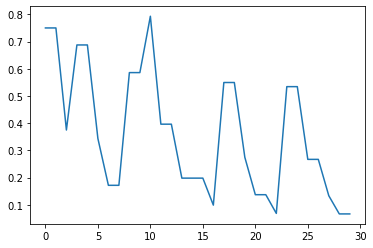

In [36]:
result = theano_llik_td(0.5, 0.5, stimVec, shockVec)
result.eval()
plt.plot(result.eval())

In [58]:
with pm.Model() as m:
    alpha = pm.Beta('alpha', 1, 1)
    beta = pm.Normal('beta',0, 10)

    #like = pm.Potential('like', theano_llik_td(alpha, beta, stimVec, shockVec))
    #like = pm.Bernoulli('like', theano_llik_td(alpha, beta, stimVec, shockVec))
    sc = pm.Normal('scr_hat',theano_llik_td(alpha, beta, stimVec, shockVec), observed=scrVec)
    tr = pm.sample(target_accept=.95)

/tmp/ipykernel_7170/2387944110.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  tr = pm.sample(target_accept=.95)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>]], dtype=object)

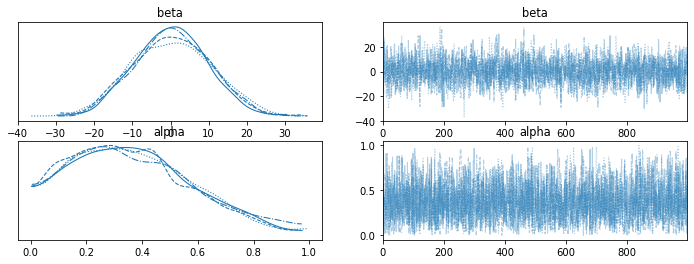

In [59]:
az.plot_trace(az.from_pymc3(tr))

In [52]:
az.summary(az.from_pymc3(tr))

Got error No model on context stack. trying to find log_likelihood in translation.
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.033,10.569,-19.508,20.822,0.198,0.199,2867.0,2022.0,1.0
alpha,0.375,0.213,0.000,0.744,0.004,0.003,2659.0,2198.0,1.0


Got error No model on context stack. trying to find log_likelihood in translation.
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<AxesSubplot:xlabel='alpha', ylabel='beta'>

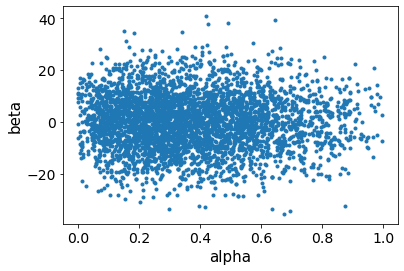

In [53]:
az.plot_pair(az.from_pymc3(tr), var_names=['alpha', 'beta'], divergences=True)

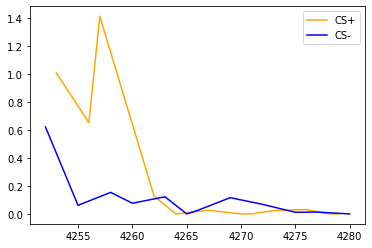

In [15]:

plt.plot(dfSub['CDA.AmpSum'][dfSub['Condition']=='CSplus1'], color='orange', label='CS+')
plt.plot(dfSub['CDA.AmpSum'][dfSub['Condition']=='CSminus1'], color = 'blue', label='CS-')
plt.legend()
#plt.plot(dfSub['CDA.PhasicMax'][dfSub['Condition']=='CSplusUS1'])

Ok. We see that plus is more than minus, but declines fast, once there are no shock. Lets try to model this

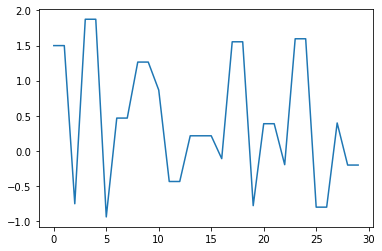

In [118]:
v = np.zeros(len(dfSub))
v[0]= 0.005 # non punishment
vp = 0.5 # punishment
alpha = 1.5#np.linspace(0.0001, 0.5, 100)
for i, event in enumerate(dfSub['Event.Nr']):
   # print(event)
    cond = dfSub['Condition'][dfSub['Event.Nr']==event].values # get condition
    if cond=='CSplusUS1': # received a shock, value updated up
      #  print(f'SHOCK {cond}')
        v[i] = v[i-1] + alpha*(1 - v[i-1])
    elif cond=='CSplus1':
       # print(f'No Shock {cond}')
        v[i] = v[i-1] + alpha*(0 - v[i-1])
    else:
        #print(f'Just a minus {cond}')
        v[i]=v[i-1]
        
    


plt.plot(v)


## Build Bayes model of that

In [96]:
# first just for the one subject
# need to change numpy to tensors
v = tt.tensor.zeros(len(dfSub))
v = tt.tensor.set_subtensor(v[0], 0.5) # set initial value for v
# try theano scan
def simple(a):
    v = tt.set_subtensor(v[i], v[i]*2)



AttributeError: 'function' object has no attribute 'zeros'

In [119]:
v = tt.zeros(len(dfSub))
v = tt.set_subtensor(v[0], 0.5) # set initial value for v
with pm.Model() as m1:
    
    
    alpha = pm.Normal('alpha', 1, 2)
    #beta = pm.HalfNormal('beta', 10)
    #eps = pm.HalfNormal('eps', 5)
    for i, event in enumerate(dfSub['Event.Nr']):
        #print(event)
        cond = dfSub['Condition'][dfSub['Event.Nr']==event].values # get condition
        if cond=='CSplusUS1': # received a shock, value updated up
        # print(f'SHOCK {cond}')
            v = tt.set_subtensor(v[i], (v[i-1] + alpha*(1 - v[i-1])))
        elif cond=='CSplus1':
        # print(f'No Shock {cond}')
            v = tt.set_subtensor(v[i], (v[i-1] + alpha*(0 - v[i-1])))
        else:
        # print(f'Just a minus {cond}')
            v = tt.set_subtensor(v[i], v[i-1])
    like = pm.Normal('y',mu=v, observed=dfSub['CDA.PhasicMax'])
    ##like = pm.Potential('like', theano_llik_td(alpha, beta, actions, rewards))

    tr = pm.sample()

/tmp/ipykernel_9807/1096623892.py:24: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  tr = pm.sample()
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]
INFO:pymc3:NUTS: [alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 11 divergences after tuning. Increase `target_accept` or reparameterize.


Try building Stan model (for loops are hard in pymc3)

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>]], dtype=object)

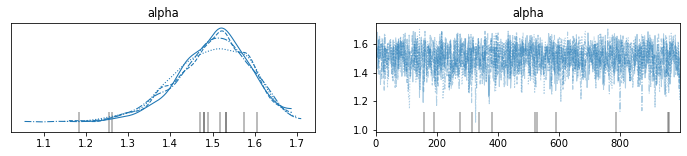

In [115]:
az.plot_trace(tr)

In [120]:
az.summary(tr)

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.83,0.225,0.438,1.271,0.005,0.004,1927.0,2861.0,1.0
